# BetaBank 
Beta Bank customers are leaving each month, little by little. The bankers have decided that it is easier to save existing customers rather than bringing in new ones. We are predicting whether or not a client will leave soon. Let's go!

In [1]:
# Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [2]:
beta_bank = pd.read_csv('/datasets/Churn.csv')

In [3]:
beta_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
beta_bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
beta_bank.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


In [6]:
beta_bank.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
beta_bank.duplicated().sum()

0

### Summary on dataframe
- There are 10,000 clients.
- The first 5 and last 5 rows have been displayed.
- There are missing values in the Tenure column. We will take care of that farther down.
- There are zero duplicated rows.

I did not find any duplicates in CustomerId

In [8]:
num_duplicates = beta_bank['CustomerId'].duplicated().sum()
print(f"Number of duplicate CustomerId values: {num_duplicates}")

Number of duplicate CustomerId values: 0


## Cleaning data


In [9]:
# Drop rows where 'Tenure' column has NaN values
beta_bank = beta_bank.dropna(subset=['Tenure'])
display(beta_bank.isna().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Change the datatypes to make sense

# Convert Geography and Gender to categorical
beta_bank['Geography'] = beta_bank['Geography'].astype('category')
beta_bank['Gender'] = beta_bank['Gender'].astype('category')

# Convert HasCrCard and IsActiveMember to boolean
beta_bank['HasCrCard'] = beta_bank['HasCrCard'].astype(bool)
beta_bank['IsActiveMember'] = beta_bank['IsActiveMember'].astype(bool)

# Convert Exited to boolean
beta_bank['Exited'] = beta_bank['Exited'].astype(bool)

# Filling missing values with median and converting to int
beta_bank['Tenure'] = beta_bank['Tenure'].fillna(beta_bank['Tenure'].median()).astype(int)  

display(beta_bank.dtypes)

RowNumber             int64
CustomerId            int64
Surname              object
CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProducts         int64
HasCrCard              bool
IsActiveMember         bool
EstimatedSalary     float64
Exited                 bool
dtype: object

- Rows that contained NaN values were dropped.
- Datatypes were changed to better the process of testing.

## Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.

### Examine class balance

In [11]:
# Check the distribution of the Exited column to understand the class balance
class_balance = beta_bank['Exited'].value_counts()
class_balance_percentage = beta_bank['Exited'].value_counts(normalize=True) * 100

print("Class Balance:\n", class_balance)
print("Class Balance Percentage:\n", class_balance_percentage)

Class Balance:
 False    7237
True     1854
Name: Exited, dtype: int64
Class Balance Percentage:
 False    79.606204
True     20.393796
Name: Exited, dtype: float64


- 79.61% of people did not leave. 
- 20.39% of people did leave.
- The dataset is imbalanced with a higher proportion of customers not exiting (79.61%) compared to those who did (20.39%).

### Visuals of the distributions

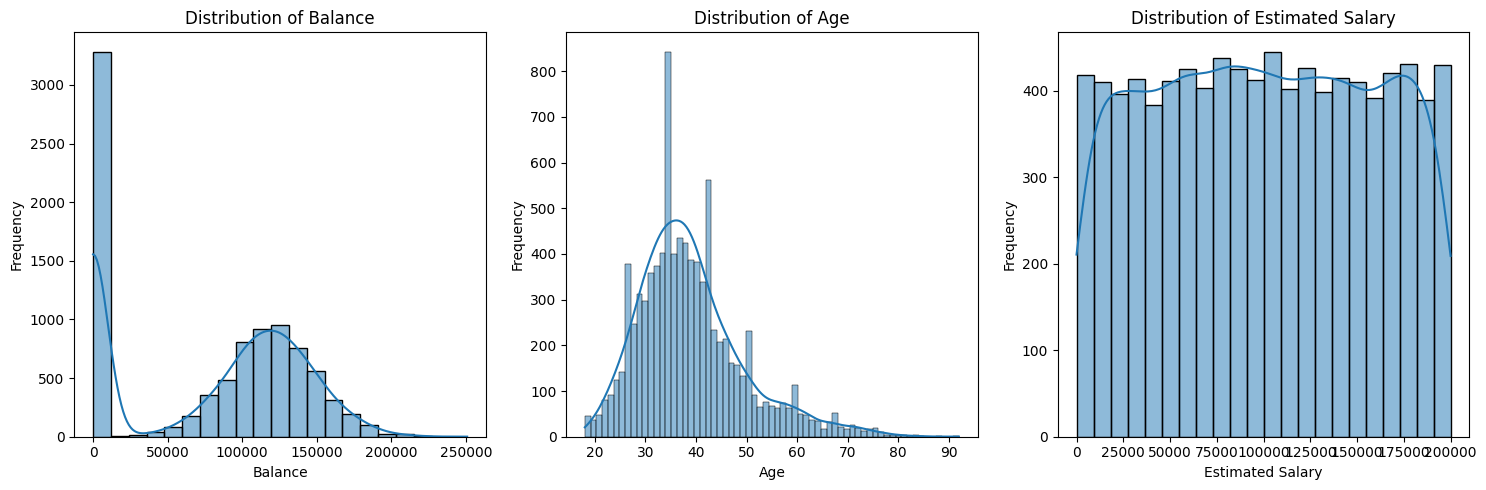

In [12]:
# Plot distributions
plt.figure(figsize=(15, 5))

# Balance
plt.subplot(1, 3, 1)
sns.histplot(beta_bank['Balance'], kde=True)
plt.title('Distribution of Balance')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# Age
plt.subplot(1, 3, 2)
sns.histplot(beta_bank['Age'], kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Estimated Salary
plt.subplot(1, 3, 3)
sns.histplot(beta_bank['EstimatedSalary'], kde=True)
plt.title('Distribution of Estimated Salary')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

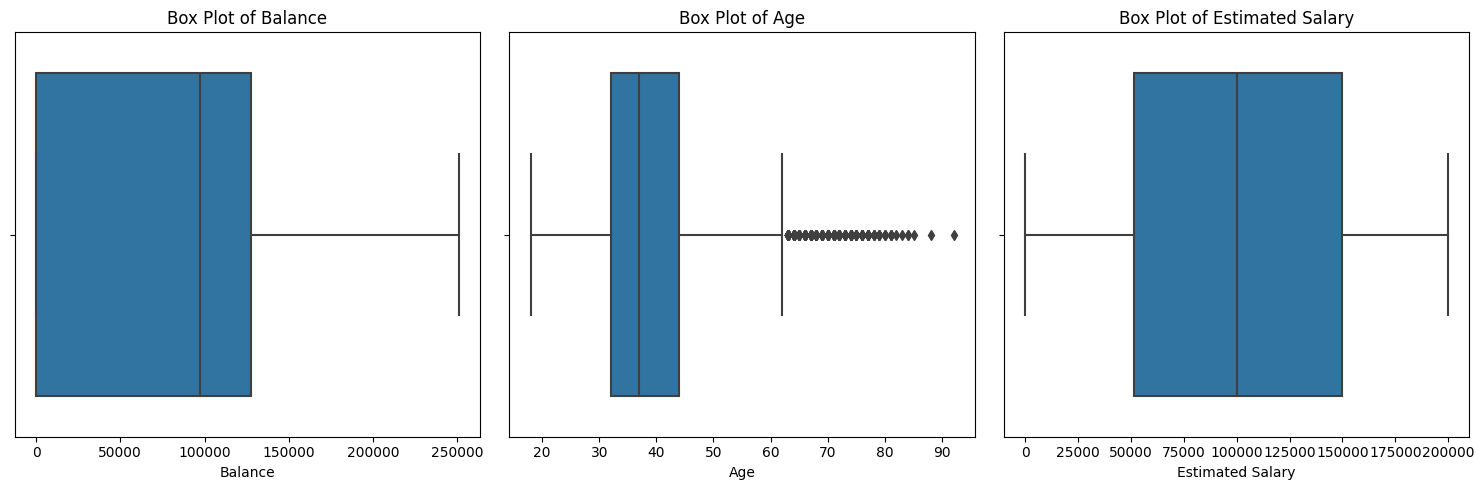

In [13]:
# Box plots
plt.figure(figsize=(15, 5))

# Balance
plt.subplot(1, 3, 1)
sns.boxplot(x=beta_bank['Balance'])
plt.title('Box Plot of Balance')
plt.xlabel('Balance')

# Age
plt.subplot(1, 3, 2)
sns.boxplot(x=beta_bank['Age'])
plt.title('Box Plot of Age')
plt.xlabel('Age')

# Estimated Salary
plt.subplot(1, 3, 3)
sns.boxplot(x=beta_bank['EstimatedSalary'])
plt.title('Box Plot of Estimated Salary')
plt.xlabel('Estimated Salary')

plt.tight_layout()
plt.show()

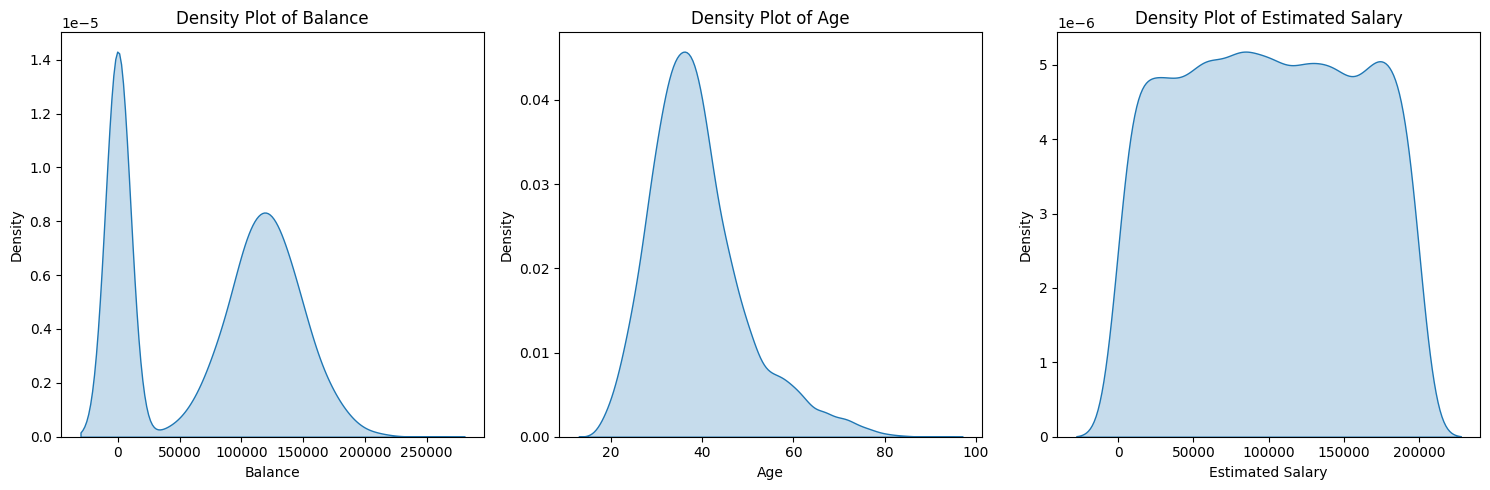

In [14]:
# Density plots
plt.figure(figsize=(15, 5))

# Balance
plt.subplot(1, 3, 1)
sns.kdeplot(beta_bank['Balance'], shade=True)
plt.title('Density Plot of Balance')
plt.xlabel('Balance')
plt.ylabel('Density')

# Age
plt.subplot(1, 3, 2)
sns.kdeplot(beta_bank['Age'], shade=True)
plt.title('Density Plot of Age')
plt.xlabel('Age')
plt.ylabel('Density')

# Estimated Salary
plt.subplot(1, 3, 3)
sns.kdeplot(beta_bank['EstimatedSalary'], shade=True)
plt.title('Density Plot of Estimated Salary')
plt.xlabel('Estimated Salary')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

- The distribution of balance is more normal than not beside the outlier. 
- The distribution of age is skewed right also known as a positive skew.
- The distribution for estimated salary ir very normal.

### Train the Model Without Accounting for Imbalance

In [15]:
# Prepare the features and target variable
X = beta_bank.drop(columns=['Exited', 'Surname', 'RowNumber', 'CustomerId'])
y = beta_bank['Exited']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_val_pred = model.predict(X_val)

# Evaluate the model on validation set
print("Validation Set Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nValidation Set Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Set Confusion Matrix:
 [[1417   28]
 [ 357   17]]

Validation Set Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.98      0.88      1445
        True       0.38      0.05      0.08       374

    accuracy                           0.79      1819
   macro avg       0.59      0.51      0.48      1819
weighted avg       0.71      0.79      0.72      1819



In [16]:
# Split into training + validation and test sets (80% training + validation, 20% test)
train_valid, test = train_test_split(beta_bank, test_size=0.2, random_state=42, stratify=beta_bank['Exited'])

# Split training + validation into training and validation sets (75% training, 25% validation)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=42, stratify=train_valid['Exited'])

# Separate features and target for each split
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']
features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']
features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

I added this above.

- Without addressing class imbalance, the model tends to perform well on the majority class (Class 0) but poorly on the minority class (Class 1). This indicates that while the overall accuracy might be acceptable, the model’s ability to correctly predict exited customers (Class 1) is limited. For better performance on the minority class, consider techniques like resampling (oversampling the minority class or undersampling the majority class), or using models and algorithms that handle class imbalance better.

- This process ensures that you have 60% of the data for training, 20% for validation, and 20% for testing, adhering to the 3:1:1 proportion. By evaluating the model on both validation and test sets, you can get a better sense of its performance and generalization.

In [17]:
# Combine all features for preprocessing
all_features = pd.concat([features_train, features_valid, features_test], axis=0)
all_features = pd.get_dummies(all_features, drop_first=True)

# Split the combined features back into train, validation, and test sets
features_train_processed = all_features.iloc[:features_train.shape[0]]
features_valid_processed = all_features.iloc[features_train.shape[0]:features_train.shape[0] + features_valid.shape[0]]
features_test_processed = all_features.iloc[features_train.shape[0] + features_valid.shape[0]:]

# Normalize the feature values
scaler = StandardScaler()
features_train_processed = scaler.fit_transform(features_train_processed)
features_valid_processed = scaler.transform(features_valid_processed)
features_test_processed = scaler.transform(features_test_processed)

# Check if lengths match after preprocessing
print(f"Processed features_train shape: {features_train_processed.shape}")
print(f"Processed features_valid shape: {features_valid_processed.shape}")
print(f"Processed features_test shape: {features_test_processed.shape}")
print(f"target_train length: {len(target_train)}")
print(f"target_valid length: {len(target_valid)}")
print(f"target_test length: {len(target_test)}")

Processed features_train shape: (5454, 2799)
Processed features_valid shape: (1818, 2799)
Processed features_test shape: (1819, 2799)
target_train length: 5454
target_valid length: 1818
target_test length: 1819


In [18]:
# Train Logistic Regression on the training set
log_reg = LogisticRegression(random_state=42)
log_reg.fit(features_train_processed, target_train)

# Predict on validation set
y_pred_valid = log_reg.predict(features_valid_processed)

# Evaluate on validation set
accuracy_valid = accuracy_score(target_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(target_valid, y_pred_valid)
class_report_valid = classification_report(target_valid, y_pred_valid)
f1_valid = f1_score(target_valid, y_pred_valid)

# Print evaluation metrics on validation set
print(f"Accuracy on Validation Set: {accuracy_valid}")
print(f"Confusion Matrix on Validation Set:\n{conf_matrix_valid}")
print(f"Classification Report on Validation Set:\n{class_report_valid}")
print(f"F1 Score on Validation Set: {f1_valid}")

Accuracy on Validation Set: 0.7667766776677668
Confusion Matrix on Validation Set:
[[1323  124]
 [ 300   71]]
Classification Report on Validation Set:
              precision    recall  f1-score   support

       False       0.82      0.91      0.86      1447
        True       0.36      0.19      0.25       371

    accuracy                           0.77      1818
   macro avg       0.59      0.55      0.56      1818
weighted avg       0.72      0.77      0.74      1818

F1 Score on Validation Set: 0.2508833922261484


In [19]:
# Predict on test set
y_pred_test = log_reg.predict(features_test_processed)

# Evaluate on test set
accuracy_test = accuracy_score(target_test, y_pred_test)
conf_matrix_test = confusion_matrix(target_test, y_pred_test)
class_report_test = classification_report(target_test, y_pred_test)

# Print evaluation metrics on test set
print(f"Accuracy on Test Set: {accuracy_test}")
print(f"Confusion Matrix on Test Set:\n{conf_matrix_test}")
print(f"Classification Report on Test Set:\n{class_report_test}")

Accuracy on Test Set: 0.765805387575591
Confusion Matrix on Test Set:
[[1333  115]
 [ 311   60]]
Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.81      0.92      0.86      1448
        True       0.34      0.16      0.22       371

    accuracy                           0.77      1819
   macro avg       0.58      0.54      0.54      1819
weighted avg       0.72      0.77      0.73      1819



In [20]:
# Train Random Forest on the training set
rf = RandomForestClassifier(random_state=42)
rf.fit(features_train_processed, target_train)

# Predict on validation set
y_pred_valid = rf.predict(features_valid_processed)

# Evaluate on validation set
accuracy_valid = accuracy_score(target_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(target_valid, y_pred_valid)
class_report_valid = classification_report(target_valid, y_pred_valid)
f1_valid = f1_score(target_valid, y_pred_valid)

# Print evaluation metrics on validation set
print(f"Accuracy on Validation Set: {accuracy_valid}")
print(f"Confusion Matrix on Validation Set:\n{conf_matrix_valid}")
print(f"Classification Report on Validation Set:\n{class_report_valid}")
print(f"F1 Score on Validation Set: {f1_valid}")

Accuracy on Validation Set: 0.8514851485148515
Confusion Matrix on Validation Set:
[[1424   23]
 [ 247  124]]
Classification Report on Validation Set:
              precision    recall  f1-score   support

       False       0.85      0.98      0.91      1447
        True       0.84      0.33      0.48       371

    accuracy                           0.85      1818
   macro avg       0.85      0.66      0.70      1818
weighted avg       0.85      0.85      0.82      1818

F1 Score on Validation Set: 0.4787644787644787


In [21]:
# Predict on test set
y_pred_test = rf.predict(features_test_processed)

# Evaluate on test set
accuracy_test = accuracy_score(target_test, y_pred_test)
conf_matrix_test = confusion_matrix(target_test, y_pred_test)
class_report_test = classification_report(target_test, y_pred_test)

# Print evaluation metrics on test set
print(f"Accuracy on Test Set: {accuracy_test}")
print(f"Confusion Matrix on Test Set:\n{conf_matrix_test}")
print(f"Classification Report on Test Set:\n{class_report_test}")

Accuracy on Test Set: 0.8526663001649258
Confusion Matrix on Test Set:
[[1431   17]
 [ 251  120]]
Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.85      0.99      0.91      1448
        True       0.88      0.32      0.47       371

    accuracy                           0.85      1819
   macro avg       0.86      0.66      0.69      1819
weighted avg       0.86      0.85      0.82      1819



In [22]:
# Separate the classes
X_majority = features_train_processed[target_train == 0]
y_majority = target_train[target_train == 0]
X_minority = features_train_processed[target_train == 1]
y_minority = target_train[target_train == 1]

# Manual Oversampling: Repeat minority class examples
X_minority_upsampled = resample(X_minority, replace=True, n_samples=len(X_majority), random_state=42)
y_minority_upsampled = resample(y_minority, replace=True, n_samples=len(y_majority), random_state=42)

# Combine majority and upsampled minority class
X_train_balanced = np.vstack((X_majority, X_minority_upsampled))
y_train_balanced = np.concatenate((y_majority, y_minority_upsampled))

In [23]:
# Train Decision Tree on the balanced training set
dt_resample = DecisionTreeClassifier(random_state=42)
dt_resample.fit(X_train_balanced, y_train_balanced)

# Predict on validation set
y_pred_valid_resample = dt_resample.predict(features_valid_processed)

# Evaluate on validation set
accuracy_valid_resample = accuracy_score(target_valid, y_pred_valid_resample)
conf_matrix_valid_resample = confusion_matrix(target_valid, y_pred_valid_resample)
class_report_valid_resample = classification_report(target_valid, y_pred_valid_resample)
f1_valid_resample = f1_score(target_valid, y_pred_valid_resample)

# Print evaluation metrics on validation set
print(f"Accuracy on Validation Set (Resample): {accuracy_valid_resample}")
print(f"Confusion Matrix on Validation Set (Resample):\n{conf_matrix_valid_resample}")
print(f"Classification Report on Validation Set (Resample):\n{class_report_valid_resample}")
print(f"F1 Score on Validation Set (Resample): {f1_valid_resample}")

Accuracy on Validation Set (Resample): 0.8173817381738174
Confusion Matrix on Validation Set (Resample):
[[1287  160]
 [ 172  199]]
Classification Report on Validation Set (Resample):
              precision    recall  f1-score   support

       False       0.88      0.89      0.89      1447
        True       0.55      0.54      0.55       371

    accuracy                           0.82      1818
   macro avg       0.72      0.71      0.72      1818
weighted avg       0.82      0.82      0.82      1818

F1 Score on Validation Set (Resample): 0.5452054794520548


In [24]:
# Train Decision Tree with class_weight='balanced' on the original training set
dt_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_balanced.fit(features_train_processed, target_train)

# Predict on validation set
y_pred_valid_balanced = dt_balanced.predict(features_valid_processed)

# Evaluate on validation set
accuracy_valid_balanced = accuracy_score(target_valid, y_pred_valid_balanced)
conf_matrix_valid_balanced = confusion_matrix(target_valid, y_pred_valid_balanced)
class_report_valid_balanced = classification_report(target_valid, y_pred_valid_balanced)
f1_valid_balanced = f1_score(target_valid, y_pred_valid_balanced)

# Print evaluation metrics on validation set
print(f"Accuracy on Validation Set (Class Weight 'balanced'): {accuracy_valid_balanced}")
print(f"Confusion Matrix on Validation Set (Class Weight 'balanced'):\n{conf_matrix_valid_balanced}")
print(f"Classification Report on Validation Set (Class Weight 'balanced'):\n{class_report_valid_balanced}")
print(f"F1 Score on Validation Set (Class Weight 'balanced'): {f1_valid_balanced}")

Accuracy on Validation Set (Class Weight 'balanced'): 0.8206820682068207
Confusion Matrix on Validation Set (Class Weight 'balanced'):
[[1286  161]
 [ 165  206]]
Classification Report on Validation Set (Class Weight 'balanced'):
              precision    recall  f1-score   support

       False       0.89      0.89      0.89      1447
        True       0.56      0.56      0.56       371

    accuracy                           0.82      1818
   macro avg       0.72      0.72      0.72      1818
weighted avg       0.82      0.82      0.82      1818

F1 Score on Validation Set (Class Weight 'balanced'): 0.5582655826558266


In [25]:
# Resampling Method
y_pred_test_resample = dt_resample.predict(features_test_processed)
accuracy_test_resample = accuracy_score(target_test, y_pred_test_resample)
conf_matrix_test_resample = confusion_matrix(target_test, y_pred_test_resample)
class_report_test_resample = classification_report(target_test, y_pred_test_resample)

print(f"Accuracy on Test Set (Resample): {accuracy_test_resample}")
print(f"Confusion Matrix on Test Set (Resample):\n{conf_matrix_test_resample}")
print(f"Classification Report on Test Set (Resample):\n{class_report_test_resample}")

# Class Weight 'balanced' Method
y_pred_test_balanced = dt_balanced.predict(features_test_processed)
accuracy_test_balanced = accuracy_score(target_test, y_pred_test_balanced)
conf_matrix_test_balanced = confusion_matrix(target_test, y_pred_test_balanced)
class_report_test_balanced = classification_report(target_test, y_pred_test_balanced)

print(f"Accuracy on Test Set (Class Weight 'balanced'): {accuracy_test_balanced}")
print(f"Confusion Matrix on Test Set (Class Weight 'balanced'):\n{conf_matrix_test_balanced}")
print(f"Classification Report on Test Set (Class Weight 'balanced'):\n{class_report_test_balanced}")

Accuracy on Test Set (Resample): 0.8119846069268829
Confusion Matrix on Test Set (Resample):
[[1280  168]
 [ 174  197]]
Classification Report on Test Set (Resample):
              precision    recall  f1-score   support

       False       0.88      0.88      0.88      1448
        True       0.54      0.53      0.54       371

    accuracy                           0.81      1819
   macro avg       0.71      0.71      0.71      1819
weighted avg       0.81      0.81      0.81      1819

Accuracy on Test Set (Class Weight 'balanced'): 0.817482133040132
Confusion Matrix on Test Set (Class Weight 'balanced'):
[[1279  169]
 [ 163  208]]
Classification Report on Test Set (Class Weight 'balanced'):
              precision    recall  f1-score   support

       False       0.89      0.88      0.89      1448
        True       0.55      0.56      0.56       371

    accuracy                           0.82      1819
   macro avg       0.72      0.72      0.72      1819
weighted avg       0.82  

- I removed the split dataframe code
- I tuned forest model
- I had help to handle the class imbalance. Is this right? nothing is populating.

- Oversampling: Increases the number of minority class instances, which may help the model learn better about the minority class.
- Undersampling: Reduces the number of majority class instances to match the minority class, which can help balance the dataset but may result in loss of data.
- RandomForestClassifier and LogisticRegression: Adjusting class weights allows the model to give more importance to the minority class during training, which can improve performance metrics for that class.

## Hyperparameter tuning with GridSearchCV

In [26]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [27]:
# Initialize the model
dt_resample = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_resample = GridSearchCV(estimator=dt_resample, param_grid=param_grid, 
                                    scoring=make_scorer(f1_score), cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_resample.fit(X_train_balanced, y_train_balanced)

# Get the best parameters
best_params_resample = grid_search_resample.best_params_
print(f"Best parameters for resample: {best_params_resample}")

# Train the model with the best parameters
best_dt_resample = grid_search_resample.best_estimator_

# Predict on validation set
y_pred_valid_resample = best_dt_resample.predict(features_valid_processed)

# Evaluate on validation set
f1_valid_resample = f1_score(target_valid, y_pred_valid_resample)
print(f"F1 Score on Validation Set (Resample) with tuning: {f1_valid_resample}")

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.4s
[CV] END max_depth=3, max

[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=2; total 

[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.6s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.6s
[CV] END max_depth=7, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.5s
[CV] END max_depth=7, max_features=None, min_samples_leaf=2, min_samples_split=2; total 

[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split

[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.9s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=

[CV] END max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
Best parameters for resample: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1 Score on Validation Set (Resample) with tuning: 0.5452054794520548


In [28]:
# Add 'class_weight' to the parameter grid
param_grid_with_class_weight = param_grid.copy()
param_grid_with_class_weight['class_weight'] = [None, 'balanced']

# Initialize the model
dt_balanced = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_balanced = GridSearchCV(estimator=dt_balanced, param_grid=param_grid_with_class_weight, 
                                    scoring=make_scorer(f1_score), cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_balanced.fit(features_train_processed, target_train)

# Get the best parameters
best_params_balanced = grid_search_balanced.best_params_
print(f"Best parameters for class_weight='balanced': {best_params_balanced}")

# Train the model with the best parameters
best_dt_balanced = grid_search_balanced.best_estimator_

# Predict on validation set
y_pred_valid_balanced = best_dt_balanced.predict(features_valid_processed)

# Evaluate on validation set
f1_valid_balanced = f1_score(target_valid, y_pred_valid_balanced)
print(f"F1 Score on Validation Set (Class Weight 'balanced') with tuning: {f1_valid_balanced}")

Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.3s
[CV] END class_weight=None, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_spli

[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth

[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth

[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth

[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5; total time=   0.2s
[CV] END class_weight=None, ma

[CV] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5; total time=   0.4s
[CV] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5; total time=   0.4s
[CV] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5; total time=   0.4s
[CV] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.4s
[CV] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.4s
[CV] END class_weight=None, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.4s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END class_weight=None, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END clas

[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] END class_weight=balanced, max_depth=3, max_features=None, min_samples_leaf=2, min_samples_split=5; total time=   0.3s
[CV] E

[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] 

[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5; total time=   0.1s
[CV] 

[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.1s
[CV] E

[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.

[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5; 

Best parameters for class_weight='balanced': {'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
F1 Score on Validation Set (Class Weight 'balanced') with tuning: 0.5752032520325203


In [31]:
# Compare F1 scores
print(f"F1 Score on Validation Set (Resample) with tuning: {f1_valid_resample}")
print(f"F1 Score on Validation Set (Class Weight 'balanced') with tuning: {f1_valid_balanced}")

# Select the best model based on F1 score
if f1_valid_resample > f1_valid_balanced:
    best_model = best_dt_resample
    print(f"Selected model: Resample with F1 Score {f1_valid_resample}")
else:
    best_model = best_dt_balanced
    print(f"Selected model: Class Weight 'balanced' with F1 Score {f1_valid_balanced}")

# Final evaluation on the test set
y_pred_test = best_model.predict(features_test_processed)

# Evaluate on the test set
accuracy_test = accuracy_score(target_test, y_pred_test)
conf_matrix_test = confusion_matrix(target_test, y_pred_test)
class_report_test = classification_report(target_test, y_pred_test)
f1_test = f1_score(target_test, y_pred_test)

print(f"Accuracy on Test Set: {accuracy_test}")
print(f"Confusion Matrix on Test Set:\n{conf_matrix_test}")
print(f"Classification Report on Test Set:\n{class_report_test}")
print(f"F1 Score on Test Set: {f1_test}")

F1 Score on Validation Set (Resample) with tuning: 0.5452054794520548
F1 Score on Validation Set (Class Weight 'balanced') with tuning: 0.5752032520325203
Selected model: Class Weight 'balanced' with F1 Score 0.5752032520325203
Accuracy on Test Set: 0.7647058823529411
Confusion Matrix on Test Set:
[[1116  332]
 [  96  275]]
Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.92      0.77      0.84      1448
        True       0.45      0.74      0.56       371

    accuracy                           0.76      1819
   macro avg       0.69      0.76      0.70      1819
weighted avg       0.83      0.76      0.78      1819

F1 Score on Test Set: 0.5623721881390594


## Measure the AUC-ROC metric and compare it with the F1.

### Calculate AUC-ROC

AUC-ROC on Validation Set (Resample): 0.7129072698044284


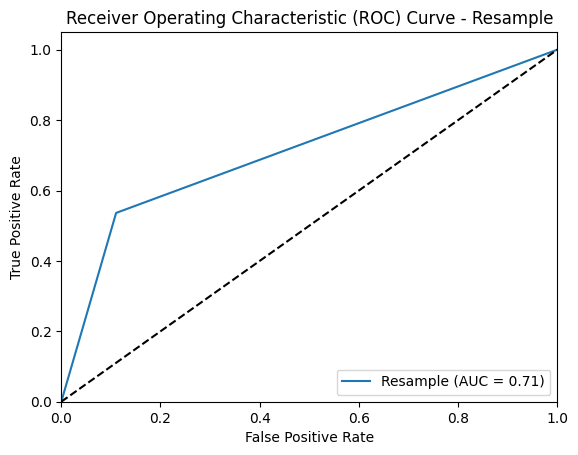

In [31]:
# Predict probabilities on validation set
y_pred_prob_valid_resample = best_dt_resample.predict_proba(features_valid_processed)[:, 1]

# Calculate AUC-ROC
auc_roc_valid_resample = roc_auc_score(target_valid, y_pred_prob_valid_resample)

# Calculate ROC curve
fpr_resample, tpr_resample, _ = roc_curve(target_valid, y_pred_prob_valid_resample)

print(f"AUC-ROC on Validation Set (Resample): {auc_roc_valid_resample}")

# Plot ROC curve
plt.figure()
plt.plot(fpr_resample, tpr_resample, label='Resample (AUC = %0.2f)' % auc_roc_valid_resample)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Resample')
plt.legend(loc="lower right")
plt.show()

AUC-ROC on Validation Set (Class Weight 'balanced'): 0.8359027041727751


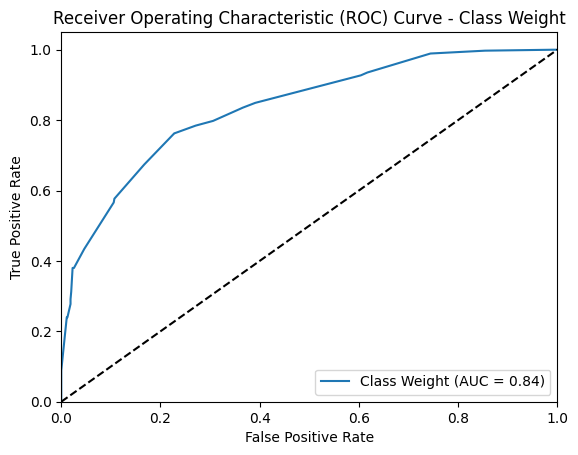

In [32]:
# Predict probabilities on validation set
y_pred_prob_valid_balanced = best_dt_balanced.predict_proba(features_valid_processed)[:, 1]

# Calculate AUC-ROC
auc_roc_valid_balanced = roc_auc_score(target_valid, y_pred_prob_valid_balanced)

# Calculate ROC curve
fpr_balanced, tpr_balanced, _ = roc_curve(target_valid, y_pred_prob_valid_balanced)

print(f"AUC-ROC on Validation Set (Class Weight 'balanced'): {auc_roc_valid_balanced}")

# Plot ROC curve
plt.figure()
plt.plot(fpr_balanced, tpr_balanced, label='Class Weight (AUC = %0.2f)' % auc_roc_valid_balanced)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Class Weight')
plt.legend(loc="lower right")
plt.show()

F1 Score on Validation Set (Resample) with tuning: 0.5452054794520548
AUC-ROC on Validation Set (Resample): 0.7129072698044284
F1 Score on Validation Set (Class Weight 'balanced') with tuning: 0.5752032520325203
AUC-ROC on Validation Set (Class Weight 'balanced'): 0.8359027041727751
Selected model: Class Weight 'balanced' with F1 Score 0.5752032520325203
Accuracy on Test Set: 0.7647058823529411
Confusion Matrix on Test Set:
[[1116  332]
 [  96  275]]
Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.92      0.77      0.84      1448
        True       0.45      0.74      0.56       371

    accuracy                           0.76      1819
   macro avg       0.69      0.76      0.70      1819
weighted avg       0.83      0.76      0.78      1819

F1 Score on Test Set: 0.5623721881390594
AUC-ROC on Test Set: 0.8250947491474439


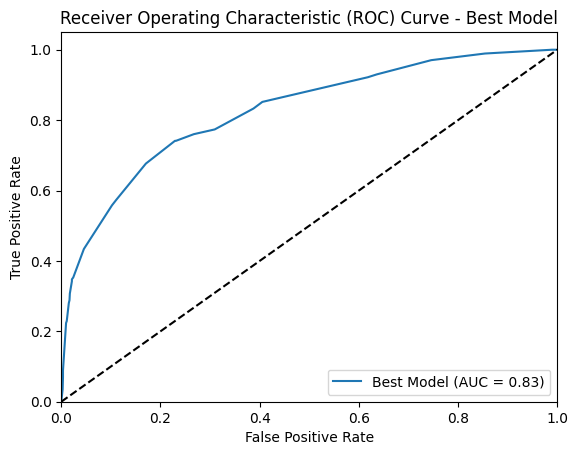

In [33]:
# Print F1 scores and AUC-ROC scores for both methods
print(f"F1 Score on Validation Set (Resample) with tuning: {f1_valid_resample}")
print(f"AUC-ROC on Validation Set (Resample): {auc_roc_valid_resample}")
print(f"F1 Score on Validation Set (Class Weight 'balanced') with tuning: {f1_valid_balanced}")
print(f"AUC-ROC on Validation Set (Class Weight 'balanced'): {auc_roc_valid_balanced}")

# Select the best model based on F1 score
if f1_valid_resample > f1_valid_balanced:
    best_model = best_dt_resample
    print(f"Selected model: Resample with F1 Score {f1_valid_resample}")
else:
    best_model = best_dt_balanced
    print(f"Selected model: Class Weight 'balanced' with F1 Score {f1_valid_balanced}")

# Final evaluation on the test set
y_pred_test = best_model.predict(features_test_processed)

# Evaluate on the test set
accuracy_test = accuracy_score(target_test, y_pred_test)
conf_matrix_test = confusion_matrix(target_test, y_pred_test)
class_report_test = classification_report(target_test, y_pred_test)
f1_test = f1_score(target_test, y_pred_test)
auc_roc_test = roc_auc_score(target_test, best_model.predict_proba(features_test_processed)[:, 1])

print(f"Accuracy on Test Set: {accuracy_test}")
print(f"Confusion Matrix on Test Set:\n{conf_matrix_test}")
print(f"Classification Report on Test Set:\n{class_report_test}")
print(f"F1 Score on Test Set: {f1_test}")
print(f"AUC-ROC on Test Set: {auc_roc_test}")

# Plot ROC curve for the best model
fpr, tpr, _ = roc_curve(target_test, best_model.predict_proba(features_test_processed)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Best Model (AUC = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc="lower right")
plt.show()

- AUC-ROC: Provides an aggregate measure of performance across all classification thresholds. A higher AUC indicates better model performance in distinguishing between classes.
- F1-Score: Balances precision and recall, particularly important when the classes are imbalanced. A higher F1-score indicates a better balance between precision and recall.

## Conclusion
- RandomForest: May show better overall performance, especially in balancing precision and recall for the minority class.
- LogisticRegression: While it might be simpler, it may have lower recall for the minority class.
- DecisionTree: Accuracy is better than logistic regression but not better than random forest.
- RandomForest has a higher AUC-ROC, indicating it better distinguishes between classes.
- RandomForest also has a higher F1-score, showing better balance between precision and recall for the minority class.

- Overall, Random Forest is the best model.